In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pandas as pd


In [ ]:
# Database connection
user = 'root'
password = '123'
host = '127.0.0.1'
port = 3306
database = 'project_db'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

In [9]:
query = """
SELECT region, 
       month, 
       price, 
       fuel_type
FROM (
    SELECT region, month, price, 'Regular' AS fuel_type FROM regular_gas_prices_canada
    UNION ALL
    SELECT region, month, price, 'Premium' AS fuel_type FROM premium_gas_prices_canada
    UNION ALL
    SELECT region, month, price, 'Diesel' AS fuel_type FROM diesel_prices_canada
) AS combined_data;
"""

In [ ]:
df_combined = pd.read_sql(query, engine)

In [14]:
df_combined['month_num'] = pd.to_datetime(df_combined['month'], format='%Y-%m').dt.month

In [15]:
df_combined['month_num'] = pd.to_datetime(df_combined['month'], errors='coerce').dt.month

print(df_combined[df_combined['month_num'].isna()])

Empty DataFrame
Columns: [region, month, price, fuel_type, month_num]
Index: []


In [16]:
# Ensure the dataframe is not empty and data has been loaded correctly
print(df_combined.head())

   region    month  price fuel_type  month_num
0  Canada  2023-10  157.4   Regular         10
1  Canada  2023-11  152.2   Regular         11
2  Canada  2023-12  145.4   Regular         12
3  Canada  2024-01  144.1   Regular          1
4  Canada  2024-02  149.9   Regular          2


In [17]:
# Prepare data for clustering
from sklearn.preprocessing import StandardScaler

In [18]:
# Select relevant columns for clustering (price and month number)
clustering_data = df_combined[['price', 'month_num']]

In [19]:
# Standardize the data to normalize scales
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

In [20]:
# Apply K-Means clustering
from sklearn.cluster import KMeans

In [21]:
# Create a K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters if needed
df_combined['cluster'] = kmeans.fit_predict(scaled_data)

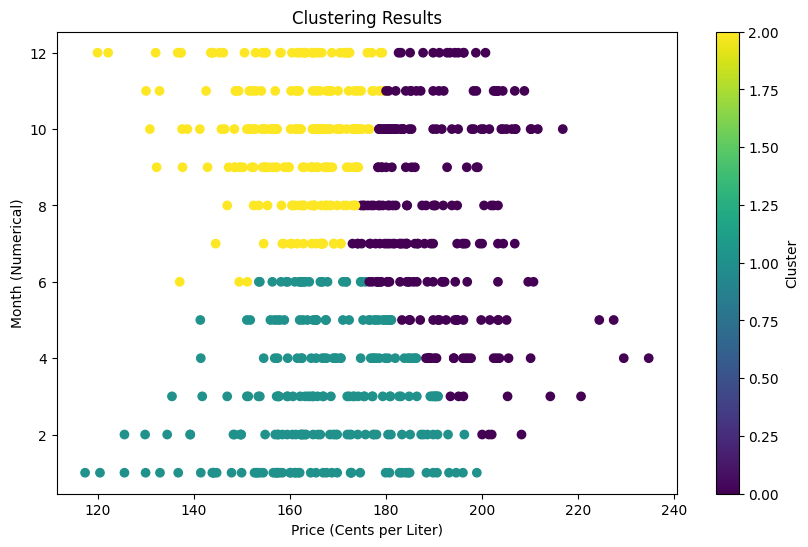

In [23]:
# Create a scatter plot for price vs month, colored by cluster assignment
plt.figure(figsize=(10, 6))
plt.scatter(
    df_combined['price'],
    df_combined['month_num'],
    c=df_combined['cluster'],
    cmap='viridis'
)
plt.colorbar(label='Cluster')  # Add a color bar to show cluster labels
plt.xlabel('Price (Cents per Liter)')
plt.ylabel('Month (Numerical)')
plt.title('Clustering Results')
plt.show()

In [25]:
# Select numeric columns for analysis
numeric_columns = df_combined.select_dtypes(include=['float64', 'int64'])

# Group by clusters and calculate mean for numeric columns only
cluster_means = numeric_columns.groupby(df_combined['cluster']).mean()

# Display the cluster statistics
print(cluster_means)

              price
cluster            
0        191.136207
1        167.096721
2        160.653540


In [26]:
for cluster_id in df_combined['cluster'].unique():
    print(f"\nCluster {cluster_id} Data:")
    print(df_combined[df_combined['cluster'] == cluster_id].head())


Cluster 2 Data:
    region    month  price fuel_type  month_num  cluster
0   Canada  2023-10  157.4   Regular         10        2
1   Canada  2023-11  152.2   Regular         11        2
2   Canada  2023-12  145.4   Regular         12        2
9   Canada  2024-07  166.5   Regular          7        2
10  Canada  2024-08  162.1   Regular          8        2

Cluster 1 Data:
   region    month  price fuel_type  month_num  cluster
3  Canada  2024-01  144.1   Regular          1        1
4  Canada  2024-02  149.9   Regular          2        1
5  Canada  2024-03  157.3   Regular          3        1
6  Canada  2024-04  169.8   Regular          4        1
7  Canada  2024-05  167.6   Regular          5        1

Cluster 0 Data:
                                   region    month  price fuel_type  \
19  St. John's, Newfoundland and Labrador  2024-04  188.4   Regular   
20  St. John's, Newfoundland and Labrador  2024-05  185.1   Regular   
21  St. John's, Newfoundland and Labrador  2024-06  177.2 